In [1]:
from pathlib import Path
from tqdm import tqdm
import sys

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
RES_DIR = WORK_DIR / "results" / "dropout"
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [4]:
##########################################################################################
# Dropout
# -------

potential = "DUNN_best_train"
eva_file = RES_DIR / "uncertainty_energy_vs_latconst.npz"
if eva_file.exists():
    eva_data = np.load(eva_file)
    alist = eva_data["alist"]
    energy_mean_do = eva_data["energy_mean"]
    energy_error_do = eva_data["energy_error"]
else:
    ainit = 2.466
    # a0, e0 = equilibrate_graphene(potential, ainit)
    alist = np.linspace(0.93, 1.09, 21) * ainit
    _, energy_mean_do, energy_error_do = energyvslatconst(
        potential, alist, lmpfile="lammps.in"
    )
    np.savez(
        eva_file, alist=alist, energy_mean=energy_mean_do, energy_error=energy_error_do
    )

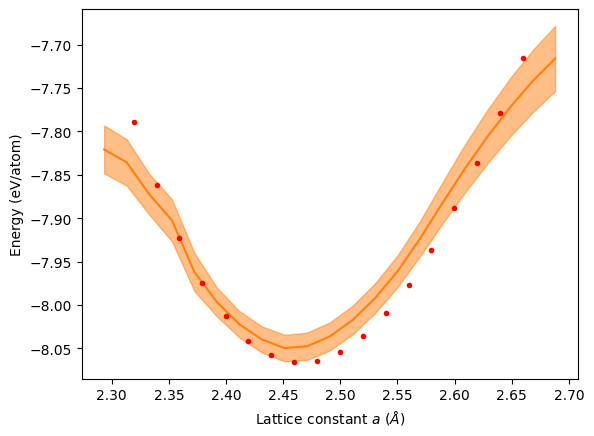

In [5]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Dropout
plt.fill_between(
    alist,
    energy_mean_do - energy_error_do,
    energy_mean_do + energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
# plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()
